In [1]:
# -*- coding: utf-8 -*-
"""

@author: cngvng
"""

import pandas as pd
import numpy as np
import time

import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.decomposition import PCA

from utils import *

types = "short"
normalized = False
binary_classify = True

data_path_unsw_train = "dataset/UNSW_NB15_training-set.csv"
data_path_unsw_test = "dataset/UNSW_NB15_testing-set.csv"

n_compnents = 16
normalized = True
binary_classify = False
label = False  # label=False for Feature Extraction

""" Processing train data and test data for pca """

# ==>process training data
data_train = preprocessing_data_unsw(data_path=data_path_unsw_train, normalized=normalized,
                                     binary_classify=binary_classify)

time_train_start = time.process_time()
y_train = data_train['label']
data_train = data_train.drop(columns=['label'])

==>start testing phase


/home/golde/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Mean Absolute Error -  0.811664966234271
Precision -  78.21370707344445
Recall -  66.80148666375165
F1 score -  72.05854469922525
Accuracy -  66.80148666375165
Running training -  0.00021542501097993494


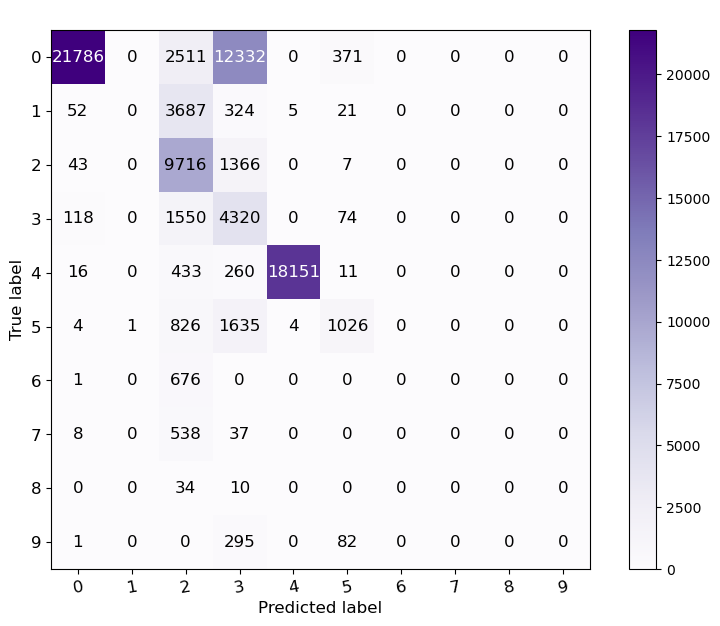

In [2]:
# feature extraction using PCA
X = data_train.to_numpy()
X_mean = np.mean(X, axis=0)
X_hat = X - X_mean
pca = PCA(n_components=n_compnents)
pca.fit(data_train)
U = pca.components_.T

X_train = np.dot(U.T, X_hat.T).T


"""Training procedure"""
# classifier = DecisionTreeClassifier(random_state=77)
classifier = RandomForestClassifier(max_depth=5, random_state=77)

time_train_start = time.process_time()
classifier.fit(X_train, y_train)
time_train_end = time.process_time()
time_train = time_train_end - time_train_start

print("==>start testing phase")
# ==>process testing data
data_test = preprocessing_data_unsw(data_path=data_path_unsw_test, normalized=normalized,
                                    binary_classify=binary_classify)
y_test = data_test['label']
data_test = data_test.drop(columns=['label'])
data_test = align_test_dataset(data_test, data_train)

time_predict_start = time.process_time()
X_test = np.dot(U.T, (data_test.to_numpy() - X_mean).T).T
y_pred = classifier.predict(X_test)
time_predict_end = time.process_time()
time_predict = (time_predict_end - time_predict_start) / len(y_test)
# end testing phase

"==>predict and print results"
y_pred = classifier.predict(X_test)
time_predict_end = time.process_time()
time_predict = (time_predict_end - time_predict_start) / len(y_test)

display_results(y_test=y_test, y_pred=y_pred, run_time=time_predict)

y_pred = pd.DataFrame(y_pred)
file_name = str(classifier) # for save figure

confusion_matrix(y_test=y_test, y_pred=y_pred, binary_classify=binary_classify, file_name=file_name, types=types)


In [3]:
X.shape, y_train.shape

((175341, 194), (175341,))

In [4]:
from sys import stdout
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
X_trainPLS = X 
y_trainPLS = y_train

In [6]:
wl = np.arange(210, 2150,10)
print(len(wl))
assert len(wl) == X_trainPLS.shape[1], 'X wavelength and wl must have the same length'

194


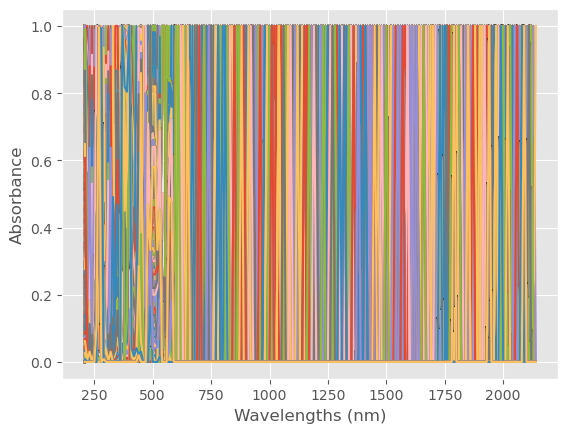

In [7]:
with plt.style.context('ggplot'):
    plt.plot(wl, X.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")
    plt.show()

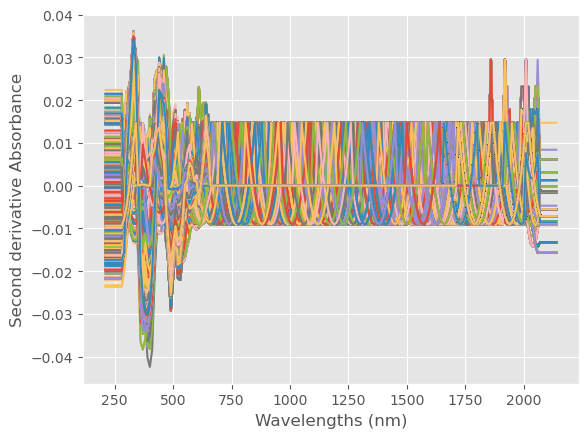

In [8]:
X2 = savgol_filter(X_trainPLS, 15, polyorder = 2, deriv=2)

with plt.style.context('ggplot'):
    plt.plot(wl, X2.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Second derivative Absorbance")
    plt.show()

In [9]:
X2.shape, X_trainPLS.shape

((175341, 194), (175341, 194))

In [10]:

def optimise_pls_cv(X, y, n_comp, plot_components=True):
 
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
 
    mse = []
    component = np.arange(1, n_comp)
 
    for i in component:
        pls = PLSRegression(n_components=i)
 
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
 
        mse.append(mean_squared_error(y, y_cv))
 
        comp = 100*(i+1)/n_comp
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
 
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
 
        plt.show()
 
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
 
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
 
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
 
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
 
        plt.show()
 
    return

100% completed
Suggested number of components:  39



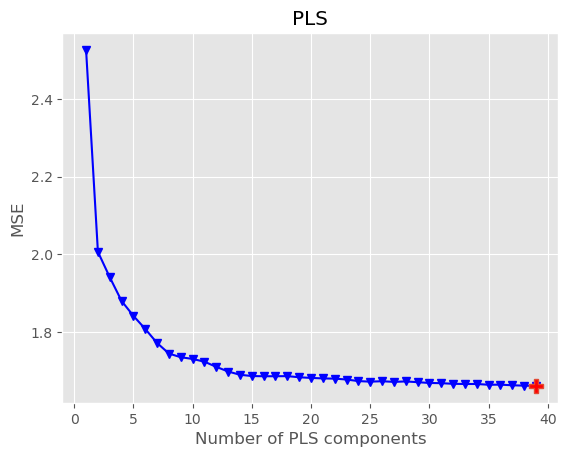

R2 calib: 0.569
R2 CV: 0.544
MSE calib: 1.572
MSE CV: 1.661


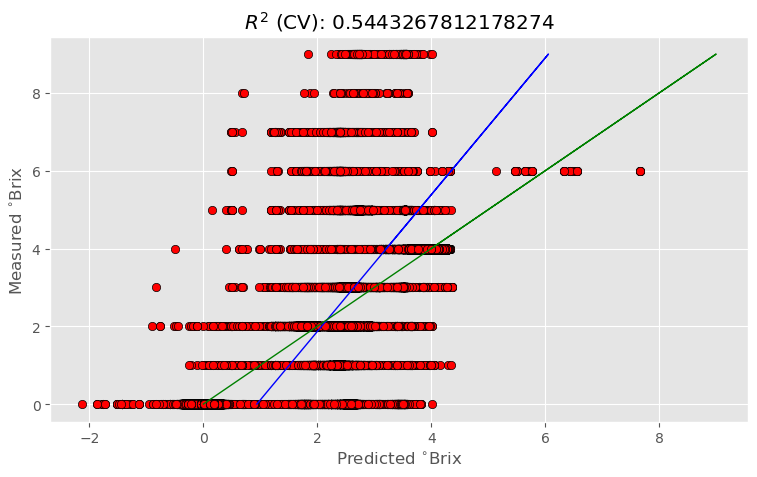

: 

In [11]:
optimise_pls_cv(X2, y_trainPLS, 40, plot_components=True)